## Part 2. Model Training & Evaluation - RNN   
Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from
Part 0, you need to train a deep learning model for sentiment classification using the training set,
conforming to these requirements:


• Use the pretrained word embeddings from Part 1 as inputs; do not update them during training
(they are “frozen”).   

• Design a simple recurrent neural network (RNN), taking the input word embeddings, and
predicting a sentiment label for each sentence. To do that, you need to consider how to
aggregate the word representations to represent a sentence.   

• Use the validation set to gauge the performance of the model for each epoch during training.
You are required to use accuracy as the performance metric during validation and evaluation. 
   
• Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g.,
SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and
mini-batch size. (You should use the validation set to determine the optimal configuration.)
Train the model until the accuracy score on the validation set is not increasing for a few
epochs.
   
• Evaluate your trained model on the test dataset, observing the accuracy score.

Import dependencies

In [1]:
import json
# We omit warnings to keep the output clean
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt 
import nltk

from common_utils import load_glove_embeddings, set_seed, EmbeddingMatrix, EarlyStopper

In [2]:
# set seed 
set_seed()

In [3]:
# initialize parameters
BATCH_SIZE = 32
INPUT_SIZE = 100 # word embedding size 
HIDDEN_SIZE = 128 # just as a starter to see 
NUM_EPOCHS = 100 
EMBEDDING_DIM=100
GRADIENT_CLIP=5

In [4]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [5]:
# initialize word embeddings
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()

print("The index of <PAD> is: ", word_embeddings.pad_idx)

The index of <PAD> is:  18030


In [6]:
word_embeddings.to_tensor[word_embeddings.pad_idx]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=torch.float64)

In [7]:
# load dataset from huggingface first 
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

with open('result/word2idx.json', "r") as file:
    word2idx = json.load(file)

In [8]:
# create train, validate and test datasets and dataloaders
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EmbeddingsDataset(Dataset):
    def __init__(self, X, y, word_embeddings:EmbeddingMatrix =word_embeddings, sort = False):
        self.word_embeddings = word_embeddings
        tokenized_sentences = []
        for sentence in X:
            tokens = self.tokenize_sentence(sentence)
            tokenized_sentences.append(tokens)

        # Combine tokens, labels, and lengths into a list of tuples
        data = list(zip(tokenized_sentences, y))
        # Sort the data based on the length of the tokenized sentences
        if sort:
            data.sort(key=lambda x: len(x[0]), reverse=False)  # Set reverse=True for descending order

        # Unzip the sorted data back into tokens and labels
        self.tokens_list, self.labels_list = zip(*data)
        self.len = len(self.tokens_list)

    def __getitem__(self, index):
        # tokenize the sentence
        return self.tokens_list[index], self.labels_list[index]

    def __len__(self):
        return self.len 

    def tokenize_sentence(self, x): 
        '''
    returns a list containing the embeddings of each token 
    '''
        tokens = nltk.word_tokenize(x)
        # word tokens to index, skip if token is not in the word embeddings
        tokens = [self.word_embeddings.get_idx(token) for token in tokens if self.word_embeddings.get_idx(token) is not None]
        return tokens


def pad_collate(batch, pad_value):
    (xx, yy) = zip(*batch)
    # convert xx to a tensor
    xx = [torch.tensor(x, dtype=torch.int64) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    return xx_pad, torch.tensor(yy, dtype=torch.long)

In [9]:
train_dataset_ed = EmbeddingsDataset(
    train_dataset["text"], train_dataset["label"]
)
validation_dataset_ed = EmbeddingsDataset(
    validation_dataset["text"], validation_dataset["label"]
)
test_dataset_ed = EmbeddingsDataset(test_dataset["text"], test_dataset["label"])

pad_value = word_embeddings.pad_idx
# implement minibatch training
train_dataloader = DataLoader(
    train_dataset_ed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
validation_dataloader = DataLoader(
    validation_dataset_ed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
test_dataloader = DataLoader(
    test_dataset_ed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)

In [81]:
train_dataset_ed_sorted = EmbeddingsDataset(
    train_dataset["text"], train_dataset["label"],
    sort=True
)
validation_dataset_ed_sorted = EmbeddingsDataset(
    validation_dataset["text"], validation_dataset["label"],
    sort=True
)
test_dataset_ed_sorted = EmbeddingsDataset(test_dataset["text"], test_dataset["label"])

pad_value = word_embeddings.pad_idx
# implement minibatch training
train_dataloader_sorted = DataLoader(
    train_dataset_ed_sorted,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
validation_dataloader_sorted = DataLoader(
    validation_dataset_ed_sorted,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
test_dataloader_sorted = DataLoader(
    test_dataset_ed_sorted,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)

In [11]:
def train_loop_bce(train_dataloader, model, loss_fn, optimizer, clipping = True):
    if train_on_gpu:
        model.cuda()
    model.train()
    num_batches = len(train_dataloader)
    size = len(train_dataloader.dataset)
    train_loss, train_correct = 0, 0
    for batch_no, (X_batch, y_batch) in enumerate(train_dataloader):
        if train_on_gpu:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
        
        # Forward pass
        pred = model(X_batch)
        
        pred = pred.squeeze(1)
        pred_binary = (pred >= 0.5).long()
        loss = loss_fn(pred, y_batch.float())
        train_loss += loss.item() 
        train_correct += (pred_binary==y_batch.long()).sum().item() 
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        if clipping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
        
        optimizer.step()
    
    train_loss /= num_batches 
    train_correct /= size 

    return train_loss, train_correct 
   

def validation_loop_bce(validate_dataloader, model, loss_fn):
    if train_on_gpu:
        model.cuda()
    model.eval()
    num_batches = len(validate_dataloader)
    size = len(validate_dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in validate_dataloader:
            if train_on_gpu:
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).long()
            test_loss += loss_fn(pred, y_batch.float()).item()
            test_correct += (pred_binary == y_batch.long()).sum().item()

    test_loss /= num_batches
    test_correct /= size
    return test_loss, test_correct

def test_performance(test_dataloader, model):
    if train_on_gpu:
        model.cuda()
    model.eval()
    size = len(test_dataloader.dataset)
    test_correct = 0

    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            if train_on_gpu:
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).long()
            test_correct += (pred_binary == y_batch.long()).sum().item()
    
    test_correct /= size
    return test_correct

In [12]:
def train(model, optim, criterion, training_dataloader, validation_dataloader, epoch = NUM_EPOCHS, clipping = True):
  validation_acc = [] 
  train_acc = []
  train_losses, validate_losses = [], []
  for i in range(epoch):
    train_loss, train_correct = train_loop_bce(training_dataloader, model, criterion, optim, clipping) 
    validate_loss, validate_correct = validation_loop_bce(validation_dataloader, model, criterion)
    validation_acc.append(validate_correct)
    train_acc.append(train_correct)
    train_losses.append(train_loss)
    validate_losses.append(validate_loss)

    print(f"Epoch {i+1}, Train Loss: {train_loss:.4f}, Validate Loss: {validate_loss:.4f}")
    #if i%10 == 0:
    print(f"Epoch:{i+1} \t Train Acc:{train_correct} \t Validation Acc:{validate_correct}")
  return train_acc, validation_acc, train_losses, validate_losses

In [13]:
def train_early_stop(model, optim, criterion, training_dataloader, validation_dataloader, clipping = True, patience = 3):
  validation_acc = [] 
  train_acc = []
  train_losses, validate_losses = [], []
  early_stopper = EarlyStopper(patience=patience)
  i = 0
  while True:
    train_loss, train_correct = train_loop_bce(training_dataloader, model, criterion, optim, clipping) 
    validate_loss, validate_correct = validation_loop_bce(validation_dataloader, model, criterion)
    validation_acc.append(validate_correct)
    train_acc.append(train_correct)
    train_losses.append(train_loss)
    validate_losses.append(validate_loss)

    print(f"Epoch {i+1}, Train Loss: {train_loss:.4f}, Validate Loss: {validate_loss:.4f}")
    #if i%10 == 0:
    print(f"Epoch:{i+1} \t Train Acc:{train_correct} \t Validation Acc:{validate_correct}")
    if early_stopper.early_stop(validate_loss):
        print("Early stopping")
        break
    i += 1
  return train_acc, validation_acc, train_losses, validate_losses

In [14]:
def plot(a: dict, x_label = "", y_label = "", title = ""):
    for key in a:
        plt.plot(a[key], label=key)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [52]:
test_accuracies = {}

## Exploration

### 1. To mask or not to mask 

Target Model: Vanilla RNN using the last hidden state

In [15]:
# using nn.Embeddings 
class VanillaRNNLastHidden(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,  embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(VanillaRNNLastHidden, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, hidden = self.rnn(x, h0)
        # Max pooling
        #out, _ = torch.max(out, dim=1)
        # Only take the last output for each sequence
        res = hidden[-1]
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)
        
        return res


#### No Mask + Fixed Length

In [16]:
# initialize word embeddings
_word_embeddings = load_glove_embeddings()

_embeddings = [_word_embeddings[word] for word in _word_embeddings.keys()]

embedding_matrix_no_mask = np.array(_embeddings)
embedding_matrix_no_mask = np.vstack((embedding_matrix_no_mask, np.zeros((1, 100)))) # add a row of zeros for padding

print(embedding_matrix_no_mask.shape)


Loading GloVe embeddings...


Repo card metadata block was not found. Setting CardData to empty.


Total GloVe words loaded: 400000
(400001, 100)


In [17]:
# TODO: change the num_tokens 
class NoMaskEmbeddingsDataset(Dataset):
  def __init__(self, X, y, num_tokens_per_sentence=25, word_embeddings=_word_embeddings):
    self.num_tokens_per_sentence = num_tokens_per_sentence
    self.word_embeddings = word_embeddings
    self.X = X # train_dataset['text']
    self.y = y # train_dataset['label']
    self.len = len(self.X)

  def __getitem__(self, index):
    # tokenize the sentence 
    tokens = self.tokenize_sentence(self.X[index])
    # convert each token to embeddings 
    sentence_tensor = self.convert_sentence_into_indices(tokens)
    label = torch.tensor(self.y[index], dtype=torch.long)
    return sentence_tensor, label 

  def __len__(self):
    return self.len 

  def tokenize_sentence(self, x): 
    '''
    returns a list containing the embeddings of each token 
    '''
    tokens = nltk.word_tokenize(x.lower())
    return tokens 
  
  def convert_sentence_into_indices(self, tokens):
    indices = []
    num_tokens_used = 0 
    for token in tokens:
      if num_tokens_used == self.num_tokens_per_sentence:
        break # we have enough of tokens from the sentence 
      if token in word2idx:
        indices.append(word2idx[token])
        num_tokens_used += 1 
    # # if not enough tokens in the sentence, use index of ?? 
    if len(indices) < self.num_tokens_per_sentence:
      padding = [(embedding_matrix_no_mask.shape[0] - 1 ) for _ in range(self.num_tokens_per_sentence - len(indices))]
      indices.extend(padding)
    #print(indices)
    indices = torch.tensor(indices, dtype=torch.long)
    return indices
  

In [18]:
no_mask_train_dataset_ed = NoMaskEmbeddingsDataset(train_dataset['text'], train_dataset['label'])
no_mask_validation_dataset_ed = NoMaskEmbeddingsDataset(validation_dataset['text'], validation_dataset['label'])
no_mask_test_dataset_ed = NoMaskEmbeddingsDataset(test_dataset['text'], test_dataset['label'])

# implement minibatch training 
no_mask_train_dataloader = DataLoader(no_mask_train_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)
no_mask_validation_dataloader = DataLoader(no_mask_validation_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)
no_mask_test_dataloader = DataLoader(no_mask_test_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)

In [88]:
vanilla_rnn = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=torch.tensor(embedding_matrix_no_mask, dtype=torch.float), padding_idx=embedding_matrix_no_mask.shape[0]-1)
optim = torch.optim.Adam(vanilla_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn_unmask, validation_acc_vanilla_rnn_unmask, train_loss_vanilla_rnn_unmask, validation_loss_vanilla_rnn_unmask = train(vanilla_rnn, optim, criterion, no_mask_train_dataloader, no_mask_validation_dataloader, epoch=50, clipping=False)

Epoch 1, Train Loss: 0.6933, Validate Loss: 0.6959
Epoch:1 	 Train Acc:0.5083235638921454 	 Validation Acc:0.49437148217636023
Epoch 2, Train Loss: 0.6900, Validate Loss: 0.6970
Epoch:2 	 Train Acc:0.5213364595545135 	 Validation Acc:0.4971857410881801
Epoch 3, Train Loss: 0.6847, Validate Loss: 0.6955
Epoch:3 	 Train Acc:0.5426729191090269 	 Validation Acc:0.5196998123827392
Epoch 4, Train Loss: 0.6748, Validate Loss: 0.6862
Epoch:4 	 Train Acc:0.5708089097303635 	 Validation Acc:0.550656660412758
Epoch 5, Train Loss: 0.6643, Validate Loss: 0.6815
Epoch:5 	 Train Acc:0.5914419695193435 	 Validation Acc:0.5647279549718575
Epoch 6, Train Loss: 0.6562, Validate Loss: 0.6831
Epoch:6 	 Train Acc:0.6090269636576788 	 Validation Acc:0.5787992495309568
Epoch 7, Train Loss: 0.6493, Validate Loss: 0.6845
Epoch:7 	 Train Acc:0.6211019929660023 	 Validation Acc:0.5666041275797373
Epoch 8, Train Loss: 0.6449, Validate Loss: 0.6950
Epoch:8 	 Train Acc:0.6254396248534584 	 Validation Acc:0.564727954

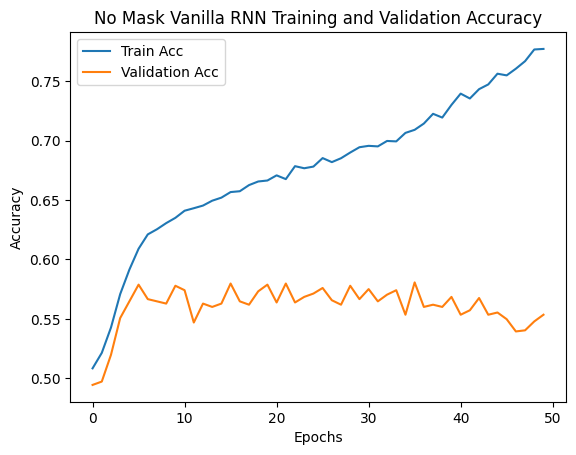

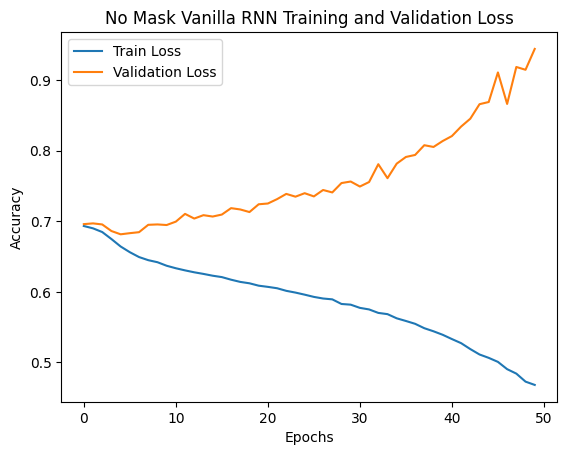

best performance (lowest validation loss) with validation acc: 0.5647279549718575 validation loss: 0.6815241855733535


In [90]:
plot({"Train Acc": train_acc_vanilla_rnn_unmask, "Validation Acc": validation_acc_vanilla_rnn_unmask}, x_label="Epochs", y_label="Accuracy", title="No Mask Vanilla RNN Training and Validation Accuracy")
plot({"Train Loss": train_loss_vanilla_rnn_unmask, "Validation Loss": validation_loss_vanilla_rnn_unmask}, x_label="Epochs", y_label="Accuracy", title="No Mask Vanilla RNN Training and Validation Loss")

i = validation_loss_vanilla_rnn_unmask.index(min(validation_loss_vanilla_rnn_unmask))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn_unmask[i], "validation loss:", validation_loss_vanilla_rnn_unmask[i])

Test Accuracy:

In [29]:
vanilla_rnn = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=torch.tensor(embedding_matrix_no_mask, dtype=torch.float), padding_idx=embedding_matrix_no_mask.shape[0]-1)
optim = torch.optim.Adam(vanilla_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn, validation_acc_vanilla_rnn, train_loss_vanilla_rnn, validation_loss_vanilla_rnn = train_early_stop(vanilla_rnn, optim, criterion, no_mask_train_dataloader, no_mask_validation_dataloader, clipping=False)

Epoch 1, Train Loss: 0.6934, Validate Loss: 0.6942
Epoch:1 	 Train Acc:0.5070339976553341 	 Validation Acc:0.49624765478424016
Epoch 2, Train Loss: 0.6895, Validate Loss: 0.6960
Epoch:2 	 Train Acc:0.5216881594372802 	 Validation Acc:0.5121951219512195
Epoch 3, Train Loss: 0.6847, Validate Loss: 0.6899
Epoch:3 	 Train Acc:0.538335287221571 	 Validation Acc:0.5384615384615384
Epoch 4, Train Loss: 0.6731, Validate Loss: 0.6781
Epoch:4 	 Train Acc:0.5845252051582649 	 Validation Acc:0.5656660412757973
Epoch 5, Train Loss: 0.6643, Validate Loss: 0.6830
Epoch:5 	 Train Acc:0.6005861664712778 	 Validation Acc:0.5666041275797373
Epoch 6, Train Loss: 0.6587, Validate Loss: 0.6764
Epoch:6 	 Train Acc:0.6126611957796014 	 Validation Acc:0.5712945590994372
Epoch 7, Train Loss: 0.6526, Validate Loss: 0.6797
Epoch:7 	 Train Acc:0.6227432590855803 	 Validation Acc:0.575046904315197
Epoch 8, Train Loss: 0.6486, Validate Loss: 0.6781
Epoch:8 	 Train Acc:0.623094958968347 	 Validation Acc:0.57879924953

In [32]:
print("Current model performance with validation acc:", validation_acc_vanilla_rnn[-1], "validation loss:", validation_loss_vanilla_rnn[-1], "\n")

test_accuracy = test_performance(no_mask_test_dataloader, vanilla_rnn)
print("No mask Vanilla RNN (last hidden state) Test accuracy:", test_accuracy)

Current model performance with validation acc: 0.5844277673545967 validation loss: 0.682578395394718 

No mask Vanilla RNN (last hidden state) Test accuracy: 0.5863039399624765


#### Masked

In [93]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn, validation_acc_vanilla_rnn, train_loss_vanilla_rnn, validation_loss_vanilla_rnn = train(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, epoch=50, clipping=False)

Epoch 1, Train Loss: 0.6935, Validate Loss: 0.6926
Epoch:1 	 Train Acc:0.4942555685814771 	 Validation Acc:0.5103189493433395
Epoch 2, Train Loss: 0.6931, Validate Loss: 0.6929
Epoch:2 	 Train Acc:0.49566236811254394 	 Validation Acc:0.5121951219512195
Epoch 3, Train Loss: 0.6930, Validate Loss: 0.6928
Epoch:3 	 Train Acc:0.4958968347010551 	 Validation Acc:0.49906191369606
Epoch 4, Train Loss: 0.6922, Validate Loss: 0.6933
Epoch:4 	 Train Acc:0.5130128956623681 	 Validation Acc:0.49624765478424016
Epoch 5, Train Loss: 0.6898, Validate Loss: 0.6458
Epoch:5 	 Train Acc:0.523915592028136 	 Validation Acc:0.6407129455909943
Epoch 6, Train Loss: 0.6196, Validate Loss: 0.6066
Epoch:6 	 Train Acc:0.6716295427901524 	 Validation Acc:0.6923076923076923
Epoch 7, Train Loss: 0.5871, Validate Loss: 0.5761
Epoch:7 	 Train Acc:0.6978898007033998 	 Validation Acc:0.7063789868667918
Epoch 8, Train Loss: 0.5674, Validate Loss: 0.5925
Epoch:8 	 Train Acc:0.7158264947245018 	 Validation Acc:0.6951219512

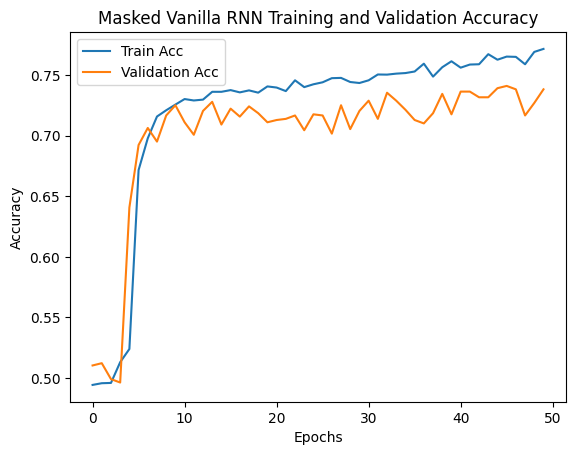

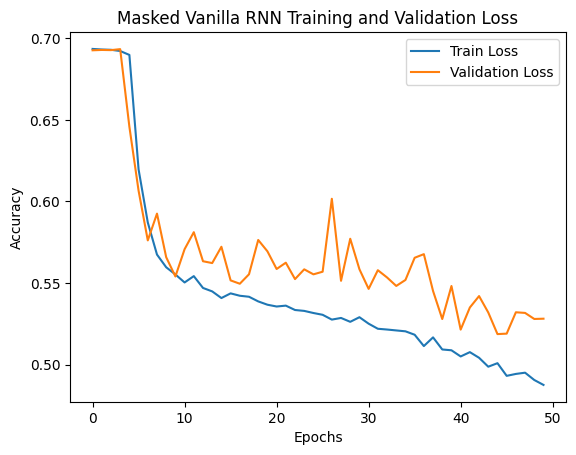

best performance (lowest validation loss) with validation acc: 0.7392120075046904 validation loss: 0.5186827770050835


In [94]:
plot({"Train Acc": train_acc_vanilla_rnn, "Validation Acc": validation_acc_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN Training and Validation Accuracy")
plot({"Train Loss": train_loss_vanilla_rnn, "Validation Loss": validation_loss_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN Training and Validation Loss")

i = validation_loss_vanilla_rnn.index(min(validation_loss_vanilla_rnn))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn[i], "validation loss:", validation_loss_vanilla_rnn[i])

Test Accuracy:

In [46]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# Since the model learns much slower, we increase the patience to 10
train_acc_vanilla_rnn, validation_acc_vanilla_rnn, train_loss_vanilla_rnn, validation_loss_vanilla_rnn = train_early_stop(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, clipping=False, patience=10)

Epoch 1, Train Loss: 0.6937, Validate Loss: 0.6928
Epoch:1 	 Train Acc:0.5043376318874561 	 Validation Acc:0.4981238273921201
Epoch 2, Train Loss: 0.6930, Validate Loss: 0.6928
Epoch:2 	 Train Acc:0.5026963657678781 	 Validation Acc:0.50093808630394
Epoch 3, Train Loss: 0.6930, Validate Loss: 0.6921
Epoch:3 	 Train Acc:0.4974208675263775 	 Validation Acc:0.5112570356472795
Epoch 4, Train Loss: 0.6928, Validate Loss: 0.6924
Epoch:4 	 Train Acc:0.5053927315357561 	 Validation Acc:0.4971857410881801
Epoch 5, Train Loss: 0.6925, Validate Loss: 0.6916
Epoch:5 	 Train Acc:0.5093786635404455 	 Validation Acc:0.49530956848030017
Epoch 6, Train Loss: 0.6899, Validate Loss: 0.6943
Epoch:6 	 Train Acc:0.529073856975381 	 Validation Acc:0.4981238273921201
Epoch 7, Train Loss: 0.6815, Validate Loss: 0.6509
Epoch:7 	 Train Acc:0.5456037514654162 	 Validation Acc:0.6472795497185742
Epoch 8, Train Loss: 0.6285, Validate Loss: 0.6192
Epoch:8 	 Train Acc:0.6688159437280188 	 Validation Acc:0.68667917448

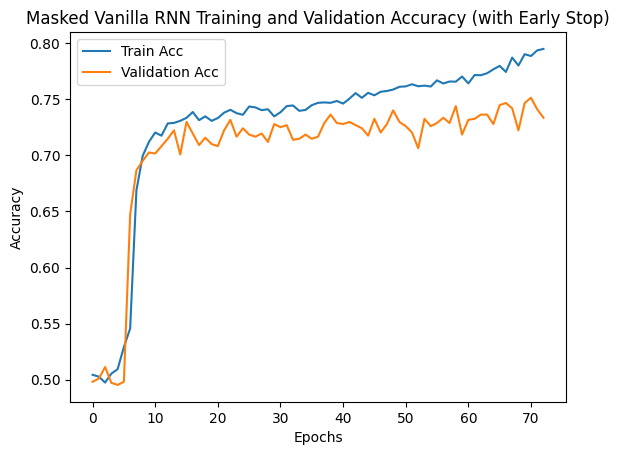

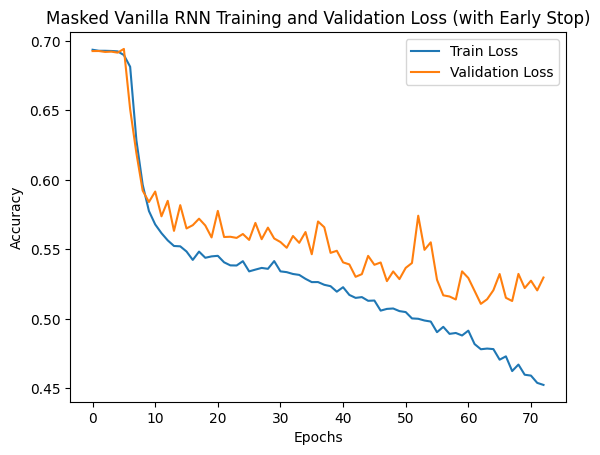

best performance (lowest validation loss) with validation acc: 0.7363977485928705 validation loss: 0.5108771271565381


In [47]:
plot({"Train Acc": train_acc_vanilla_rnn, "Validation Acc": validation_acc_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN Training and Validation Accuracy (with Early Stop)")
plot({"Train Loss": train_loss_vanilla_rnn, "Validation Loss": validation_loss_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN Training and Validation Loss (with Early Stop)")

i = validation_loss_vanilla_rnn.index(min(validation_loss_vanilla_rnn))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn[i], "validation loss:", validation_loss_vanilla_rnn[i])

In [48]:
print("Last Masked Vanilla RNN performance with validation acc:", validation_acc_vanilla_rnn[-1], "validation loss:", validation_loss_vanilla_rnn[-1], "\n")

test_accuracy = test_performance(test_dataloader, vanilla_rnn_hidden)
print("Masked Vanilla RNN (last hidden state) Test accuracy:", test_accuracy)

Last Masked Vanilla RNN performance with validation acc: 0.7335834896810507 validation loss: 0.5298320081304101 

Masked Vanilla RNN (last hidden state) Test accuracy: 0.7382739212007504


##### Some cool observation:
Notice if learning rate is higher than 0.0001 (e.g. >0.0002 here), the model will not converge.

In [39]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0002)
criterion = nn.BCELoss()

train_acc_vanilla_rnn_high, validation_acc_vanilla_rnn_high, train_loss_vanilla_rnn_high, validation_loss_vanilla_rnn_high = train(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, epoch=50, clipping=False)

Epoch 1, Train Loss: 0.6934, Validate Loss: 0.6926
Epoch:1 	 Train Acc:0.5060961313012896 	 Validation Acc:0.49530956848030017
Epoch 2, Train Loss: 0.6934, Validate Loss: 0.6947
Epoch:2 	 Train Acc:0.5038686987104337 	 Validation Acc:0.5
Epoch 3, Train Loss: 0.6933, Validate Loss: 0.6928
Epoch:3 	 Train Acc:0.4981242672919109 	 Validation Acc:0.4924953095684803
Epoch 4, Train Loss: 0.6924, Validate Loss: 0.6952
Epoch:4 	 Train Acc:0.5066822977725675 	 Validation Acc:0.5028142589118199
Epoch 5, Train Loss: 0.6927, Validate Loss: 0.6922
Epoch:5 	 Train Acc:0.4969519343493552 	 Validation Acc:0.5112570356472795
Epoch 6, Train Loss: 0.6938, Validate Loss: 0.6931
Epoch:6 	 Train Acc:0.5114888628370458 	 Validation Acc:0.4971857410881801
Epoch 7, Train Loss: 0.6924, Validate Loss: 0.6938
Epoch:7 	 Train Acc:0.5028135990621336 	 Validation Acc:0.49906191369606
Epoch 8, Train Loss: 0.6928, Validate Loss: 0.6959
Epoch:8 	 Train Acc:0.5038686987104337 	 Validation Acc:0.5093808630393997
Epoch 9,

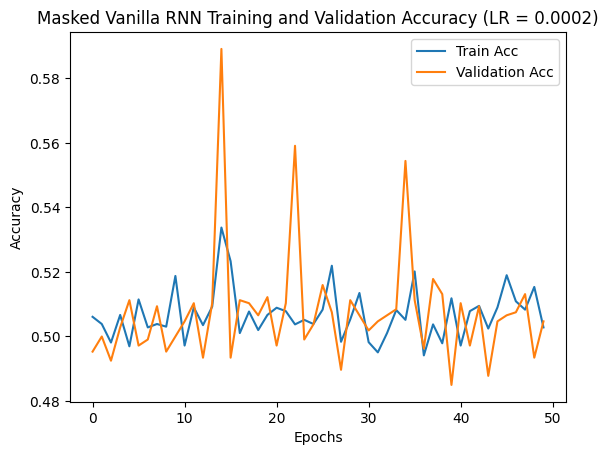

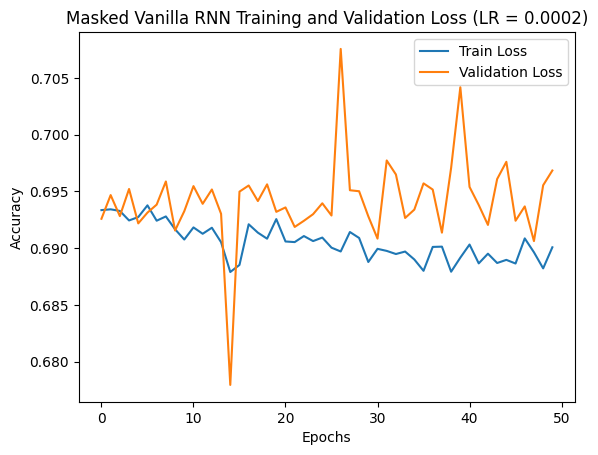

best performance (lowest validation loss) with validation acc: 0.5891181988742964 validation loss: 0.6779545633231893


In [91]:
plot({"Train Acc": train_acc_vanilla_rnn_high, "Validation Acc": validation_acc_vanilla_rnn_high}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN Training and Validation Accuracy (LR = 0.0002)")
plot({"Train Loss": train_loss_vanilla_rnn_high, "Validation Loss": validation_loss_vanilla_rnn_high}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN Training and Validation Loss (LR = 0.0002)")

i = validation_loss_vanilla_rnn_high.index(min(validation_loss_vanilla_rnn_high))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn_high[i], "validation loss:", validation_loss_vanilla_rnn_high[i])

### 1.5 Gradient Clipping

We notice that there is a drastic changes during the training.

We decide to introduce gradient clipping to take a much smaller step when updating the gradient. 

With this, we can update the gradient much smoother and reduce the risk of overshooting during optimization. This helps the model converge more steadily, as shown below.

In [50]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn_clip, validation_acc_vanilla_rnn_clip, train_loss_vanilla_rnn_clip, validation_loss_vanilla_rnn_clip = train(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, epoch=50, clipping=True)

Epoch 1, Train Loss: 0.6934, Validate Loss: 0.6938
Epoch:1 	 Train Acc:0.5055099648300118 	 Validation Acc:0.50187617260788
Epoch 2, Train Loss: 0.6933, Validate Loss: 0.6943
Epoch:2 	 Train Acc:0.49894490035169986 	 Validation Acc:0.49530956848030017
Epoch 3, Train Loss: 0.6931, Validate Loss: 0.6934
Epoch:3 	 Train Acc:0.5 	 Validation Acc:0.49624765478424016
Epoch 4, Train Loss: 0.6926, Validate Loss: 0.6948
Epoch:4 	 Train Acc:0.5046893317702228 	 Validation Acc:0.4924953095684803
Epoch 5, Train Loss: 0.6928, Validate Loss: 0.6937
Epoch:5 	 Train Acc:0.48968347010550994 	 Validation Acc:0.49437148217636023
Epoch 6, Train Loss: 0.6928, Validate Loss: 0.6970
Epoch:6 	 Train Acc:0.5132473622508793 	 Validation Acc:0.5
Epoch 7, Train Loss: 0.6929, Validate Loss: 0.6937
Epoch:7 	 Train Acc:0.5003516998827667 	 Validation Acc:0.4971857410881801
Epoch 8, Train Loss: 0.6924, Validate Loss: 0.6920
Epoch:8 	 Train Acc:0.4984759671746776 	 Validation Acc:0.5065666041275797
Epoch 9, Train Loss

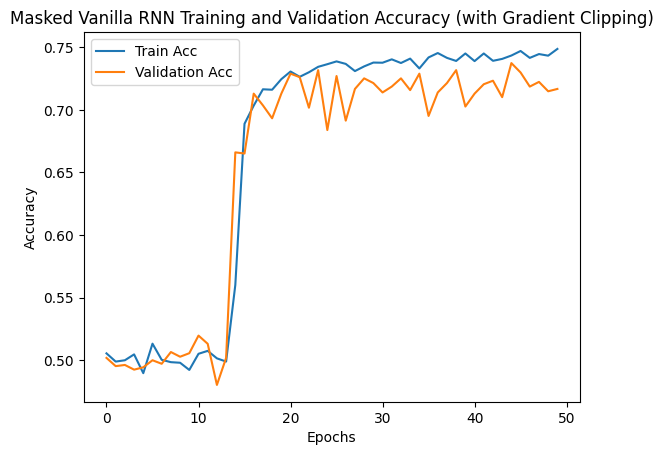

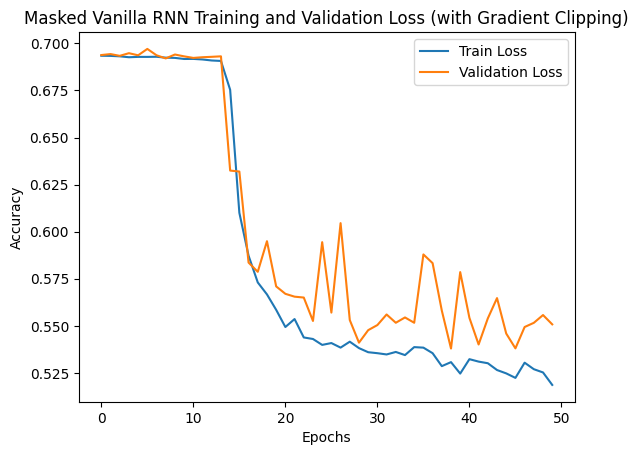

best performance (lowest validation loss) with validation acc: 0.7317073170731707 validation loss: 0.5379227084272048


In [51]:
plot({"Train Acc": train_acc_vanilla_rnn_clip, "Validation Acc": validation_acc_vanilla_rnn_clip}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN Training and Validation Accuracy (with Gradient Clipping)")
plot({"Train Loss": train_loss_vanilla_rnn_clip, "Validation Loss": validation_loss_vanilla_rnn_clip}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN Training and Validation Loss (with Gradient Clipping)")

i = validation_loss_vanilla_rnn_clip.index(min(validation_loss_vanilla_rnn_clip))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn_clip[i], "validation loss:", validation_loss_vanilla_rnn_clip[i])

Test Accuracy:

In [53]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# Since the model learns much slower, we increase the patience to 10
train_acc_vanilla_rnn_clip_2, validation_acc_vanilla_rnn_clip_2, train_loss_vanilla_rnn_clip_2, validation_loss_vanilla_rnn_clip_2 = train_early_stop(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, clipping=True, patience=10)

Epoch 1, Train Loss: 0.6938, Validate Loss: 0.6923
Epoch:1 	 Train Acc:0.5007033997655335 	 Validation Acc:0.50093808630394
Epoch 2, Train Loss: 0.6932, Validate Loss: 0.6924
Epoch:2 	 Train Acc:0.5007033997655335 	 Validation Acc:0.5140712945590994
Epoch 3, Train Loss: 0.6931, Validate Loss: 0.6934
Epoch:3 	 Train Acc:0.5033997655334115 	 Validation Acc:0.5046904315196998
Epoch 4, Train Loss: 0.6925, Validate Loss: 0.6932
Epoch:4 	 Train Acc:0.5077373974208675 	 Validation Acc:0.5093808630393997
Epoch 5, Train Loss: 0.6925, Validate Loss: 0.6913
Epoch:5 	 Train Acc:0.49894490035169986 	 Validation Acc:0.49343339587242024
Epoch 6, Train Loss: 0.6908, Validate Loss: 0.6971
Epoch:6 	 Train Acc:0.5202813599062134 	 Validation Acc:0.5028142589118199
Epoch 7, Train Loss: 0.6927, Validate Loss: 0.6934
Epoch:7 	 Train Acc:0.5024618991793669 	 Validation Acc:0.5168855534709194
Epoch 8, Train Loss: 0.6914, Validate Loss: 0.6923
Epoch:8 	 Train Acc:0.4978898007033998 	 Validation Acc:0.529080675

In [62]:
print("Last Masked Vanilla RNN (with Gradient Clipping) performance with validation acc:", validation_acc_vanilla_rnn_clip_2[-1], "validation loss:", validation_loss_vanilla_rnn_clip_2[-1], "\n")

test_accuracy = test_performance(test_dataloader, vanilla_rnn_hidden)
print("Masked Vanilla RNN (with Gradient Clipping)Test accuracy:", test_accuracy)

Last Masked Vanilla RNN (with Gradient Clipping) performance with validation acc: 0.7120075046904315 validation loss: 0.5560132983852836 

Masked Vanilla RNN (with Gradient Clipping)Test accuracy: 0.7213883677298312


#### 1.7 Sorting the dataset

From Woon Yee's...

In [84]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn, validation_acc_vanilla_rnn, train_loss_vanilla_rnn, validation_loss_vanilla_rnn = train_early_stop(vanilla_rnn_hidden, optim, criterion, train_dataloader_sorted, validation_dataloader_sorted, clipping=True, patience=5)

Epoch 1, Train Loss: 0.6729, Validate Loss: 0.6271
Epoch:1 	 Train Acc:0.5683470105509965 	 Validation Acc:0.6716697936210131
Epoch 2, Train Loss: 0.6319, Validate Loss: 0.5871
Epoch:2 	 Train Acc:0.6343493552168816 	 Validation Acc:0.7045028142589118
Epoch 3, Train Loss: 0.6076, Validate Loss: 0.5725
Epoch:3 	 Train Acc:0.6716295427901524 	 Validation Acc:0.7110694183864915
Epoch 4, Train Loss: 0.6011, Validate Loss: 0.5710
Epoch:4 	 Train Acc:0.6781946072684643 	 Validation Acc:0.7176360225140713
Epoch 5, Train Loss: 0.5972, Validate Loss: 0.5698
Epoch:5 	 Train Acc:0.6832356389214537 	 Validation Acc:0.7195121951219512
Epoch 6, Train Loss: 0.5944, Validate Loss: 0.5681
Epoch:6 	 Train Acc:0.6859320046893318 	 Validation Acc:0.7213883677298312
Epoch 7, Train Loss: 0.5920, Validate Loss: 0.5677
Epoch:7 	 Train Acc:0.6881594372801876 	 Validation Acc:0.725140712945591
Epoch 8, Train Loss: 0.5900, Validate Loss: 0.5662
Epoch:8 	 Train Acc:0.6916764361078547 	 Validation Acc:0.7279549718

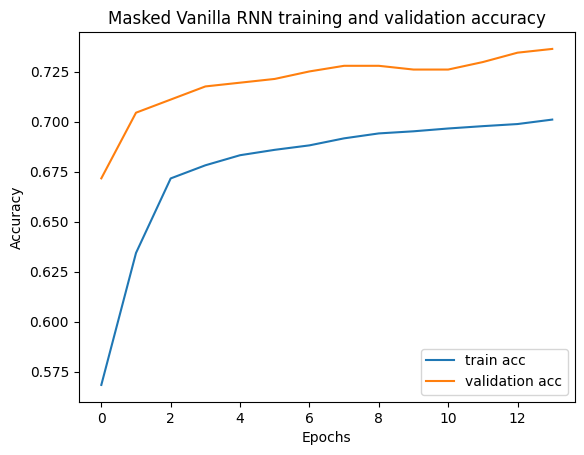

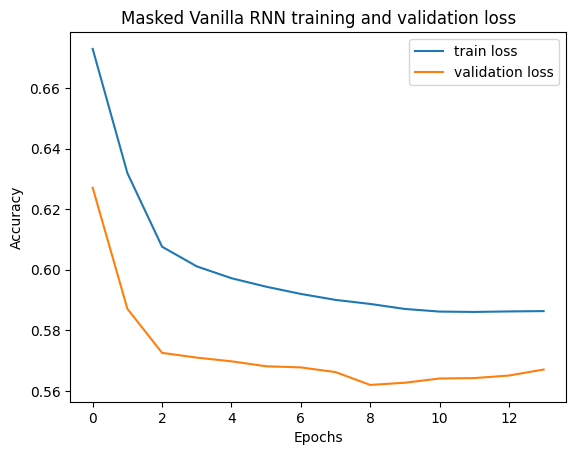

best performance with validation acc: 0.7363977485928705 validation loss: 0.567032419364242


In [85]:
plot({"train acc": train_acc_vanilla_rnn, "validation acc": validation_acc_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN training and validation accuracy")
plot({"train loss": train_loss_vanilla_rnn, "validation loss": validation_loss_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN training and validation loss")

i = validation_loss_vanilla_rnn.index(min(validation_loss_vanilla_rnn))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn[i], "validation loss:", validation_loss_vanilla_rnn[i])

### 2. Max pooling, Sum pooling and Avg Pooling

#### Last output RNN

In [119]:
# using nn.Embeddings 
import torch
import torch.nn as nn

class LastOutputRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(LastOutputRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Get the last output for each sequence
        res = out[:, -1, :]
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

In [123]:
last_output_rnn = LastOutputRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(last_output_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_last_output, validation_acc_last_output, train_loss_last_output, validation_loss_last_output = train(last_output_rnn, optim, criterion, train_dataloader, validation_dataloader, epoch=50)

Epoch 1, Train Loss: 0.6935, Validate Loss: 0.6920
Epoch:1 	 Train Acc:0.4902696365767878 	 Validation Acc:0.50187617260788
Epoch 2, Train Loss: 0.6935, Validate Loss: 0.6939
Epoch:2 	 Train Acc:0.49718640093786637 	 Validation Acc:0.50187617260788
Epoch 3, Train Loss: 0.6928, Validate Loss: 0.6919
Epoch:3 	 Train Acc:0.5079718640093787 	 Validation Acc:0.5131332082551595
Epoch 4, Train Loss: 0.6928, Validate Loss: 0.6932
Epoch:4 	 Train Acc:0.5072684642438453 	 Validation Acc:0.5028142589118199
Epoch 5, Train Loss: 0.6924, Validate Loss: 0.6928
Epoch:5 	 Train Acc:0.5063305978898007 	 Validation Acc:0.5056285178236398
Epoch 6, Train Loss: 0.6906, Validate Loss: 0.6882
Epoch:6 	 Train Acc:0.5155920281359906 	 Validation Acc:0.5684803001876173
Epoch 7, Train Loss: 0.6347, Validate Loss: 0.6069
Epoch:7 	 Train Acc:0.6608440797186401 	 Validation Acc:0.6866791744840526
Epoch 8, Train Loss: 0.5862, Validate Loss: 0.6044
Epoch:8 	 Train Acc:0.7025791324736225 	 Validation Acc:0.694183864915

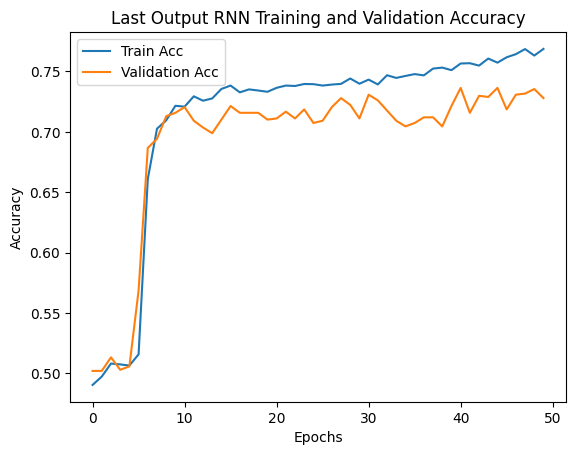

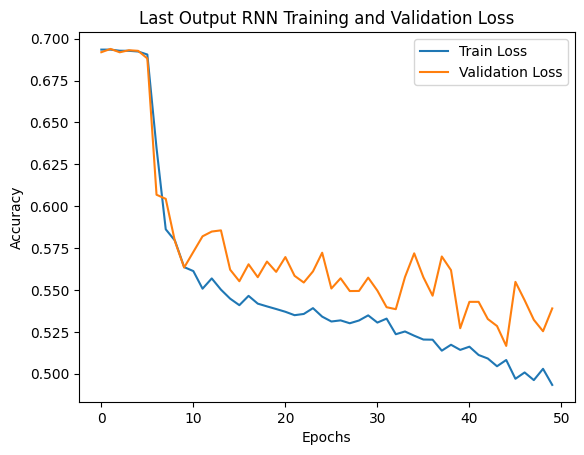

best performance (lowest validation loss) with validation acc: 0.7363977485928705 validation loss: 0.5165823943474713


In [124]:
plot({"Train Acc": train_acc_last_output, "Validation Acc": validation_acc_last_output}, x_label="Epochs", y_label="Accuracy", title="Last Output RNN Training and Validation Accuracy")
plot({"Train Loss": train_loss_last_output, "Validation Loss": validation_loss_last_output}, x_label="Epochs", y_label="Accuracy", title="Last Output RNN Training and Validation Loss")

i = validation_loss_last_output.index(min(validation_loss_last_output))
print("best performance (lowest validation loss) with validation acc:", validation_acc_last_output[i], "validation loss:", validation_loss_last_output[i])

Test Accuracy:

In [128]:
last_output_rnn = LastOutputRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(last_output_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# Since the model learns much slower, we increase the patience to 10
train_acc_last_output, validation_acc_last_output, train_loss_last_output, validation_loss_last_output = train_early_stop(last_output_rnn, optim, criterion, train_dataloader, validation_dataloader, patience = 10)

Epoch 1, Train Loss: 0.6937, Validate Loss: 0.6926
Epoch:1 	 Train Acc:0.4997655334114889 	 Validation Acc:0.5046904315196998
Epoch 2, Train Loss: 0.6935, Validate Loss: 0.6939
Epoch:2 	 Train Acc:0.4966002344665885 	 Validation Acc:0.50093808630394
Epoch 3, Train Loss: 0.6932, Validate Loss: 0.6940
Epoch:3 	 Train Acc:0.5041031652989449 	 Validation Acc:0.4971857410881801
Epoch 4, Train Loss: 0.6930, Validate Loss: 0.6931
Epoch:4 	 Train Acc:0.5030480656506447 	 Validation Acc:0.5065666041275797
Epoch 5, Train Loss: 0.6928, Validate Loss: 0.6927
Epoch:5 	 Train Acc:0.4926143024618992 	 Validation Acc:0.4981238273921201
Epoch 6, Train Loss: 0.6926, Validate Loss: 0.6921
Epoch:6 	 Train Acc:0.49894490035169986 	 Validation Acc:0.5121951219512195
Epoch 7, Train Loss: 0.6921, Validate Loss: 0.6938
Epoch:7 	 Train Acc:0.49132473622508793 	 Validation Acc:0.4981238273921201
Epoch 8, Train Loss: 0.6912, Validate Loss: 0.6944
Epoch:8 	 Train Acc:0.5173505275498241 	 Validation Acc:0.502814258

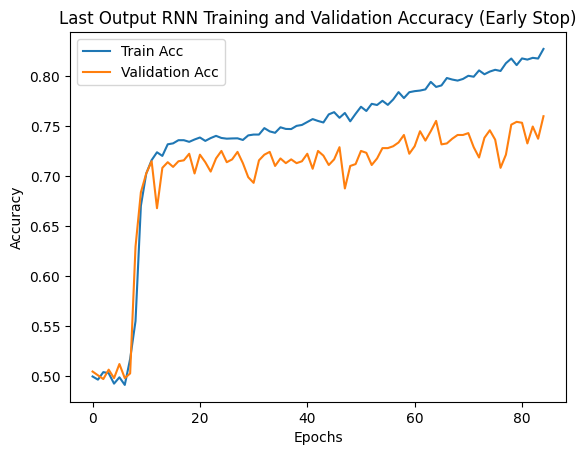

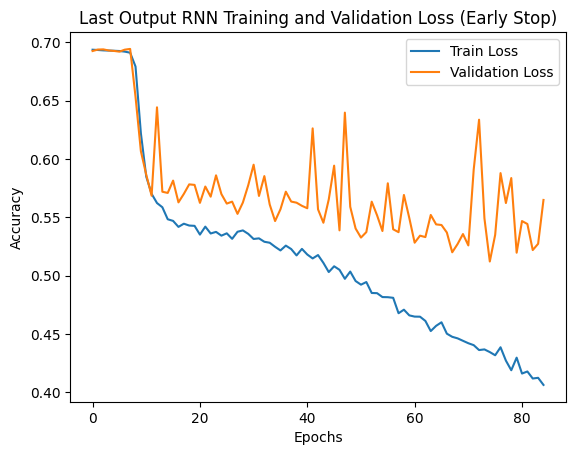

best performance (lowest validation loss) with validation acc: 0.7457786116322702 validation loss: 0.5122129619121552


In [129]:
plot({"Train Acc": train_acc_last_output, "Validation Acc": validation_acc_last_output}, x_label="Epochs", y_label="Accuracy", title="Last Output RNN Training and Validation Accuracy (Early Stop)")
plot({"Train Loss": train_loss_last_output, "Validation Loss": validation_loss_last_output}, x_label="Epochs", y_label="Accuracy", title="Last Output RNN Training and Validation Loss (Early Stop)")

i = validation_loss_last_output.index(min(validation_loss_last_output))
print("best performance (lowest validation loss) with validation acc:", validation_acc_last_output[i], "validation loss:", validation_loss_last_output[i])

In [130]:
print("Last Max Pooling RNN performance with validation acc:", validation_acc_last_output[-1], "validation loss:", validation_loss_last_output[-1], "\n")

test_accuracy = test_performance(test_dataloader, last_output_rnn)
print("Masked Max Pooling RNN Test accuracy:", test_accuracy)

Last Max Pooling RNN performance with validation acc: 0.7598499061913696 validation loss: 0.5649592381189851 

Masked Max Pooling RNN Test accuracy: 0.7467166979362101


#### Max pooling RNN

In [ ]:
# using nn.Embeddings 
import torch
import torch.nn as nn

class MaxPoolRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(MaxPoolRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Max pooling
        # TODO: try with absolute
        res, _ = torch.max(out, dim=1)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

In [87]:
max_pool_rnn = MaxPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(max_pool_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc, validation_acc, train_loss, validation_loss = train(max_pool_rnn, optim, criterion, train_dataloader, validation_dataloader, epoch=50)

Epoch 1, Train Loss: 0.6669, Validate Loss: 0.6003
Epoch:1 	 Train Acc:0.5957796014067995 	 Validation Acc:0.6819887429643527
Epoch 2, Train Loss: 0.5838, Validate Loss: 0.5756
Epoch:2 	 Train Acc:0.6949589683470105 	 Validation Acc:0.6979362101313321
Epoch 3, Train Loss: 0.5516, Validate Loss: 0.5568
Epoch:3 	 Train Acc:0.71957796014068 	 Validation Acc:0.7082551594746717
Epoch 4, Train Loss: 0.5393, Validate Loss: 0.5409
Epoch:4 	 Train Acc:0.7264947245017584 	 Validation Acc:0.7335834896810507
Epoch 5, Train Loss: 0.5237, Validate Loss: 0.5429
Epoch:5 	 Train Acc:0.7391559202813599 	 Validation Acc:0.7354596622889306
Epoch 6, Train Loss: 0.5114, Validate Loss: 0.5271
Epoch:6 	 Train Acc:0.7460726846424385 	 Validation Acc:0.7439024390243902
Epoch 7, Train Loss: 0.4988, Validate Loss: 0.5274
Epoch:7 	 Train Acc:0.7577960140679953 	 Validation Acc:0.7401500938086304
Epoch 8, Train Loss: 0.4928, Validate Loss: 0.5116
Epoch:8 	 Train Acc:0.758147713950762 	 Validation Acc:0.749530956848

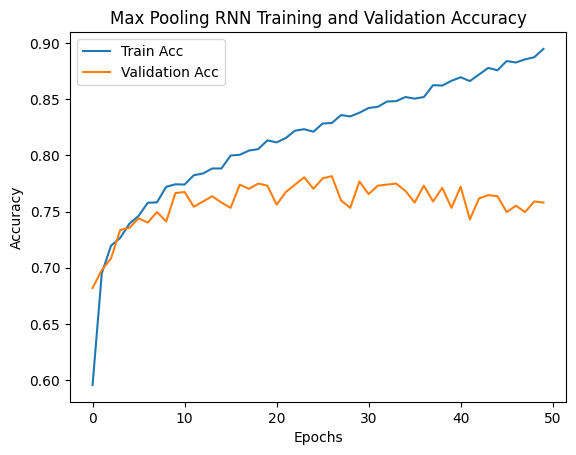

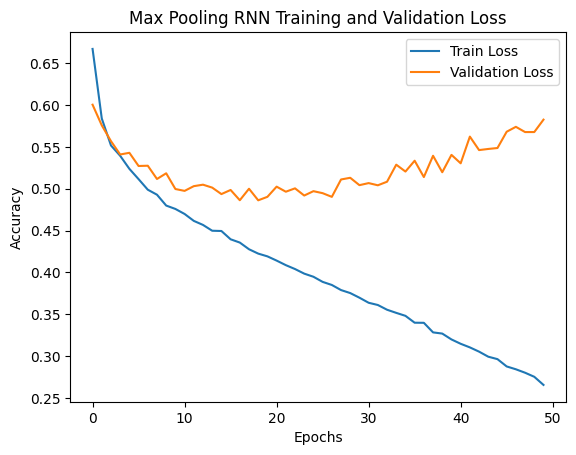

best performance (lowest validation loss) with validation acc: 0.774859287054409 validation loss: 0.48611695187933307


In [97]:
plot({"Train Acc": train_acc, "Validation Acc": validation_acc}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Accuracy")
plot({"Train Loss": train_loss, "Validation Loss": validation_loss}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Loss")

i = validation_loss.index(min(validation_loss))
print("best performance (lowest validation loss) with validation acc:", validation_acc[i], "validation loss:", validation_loss[i])

Test Accuracy:

In [98]:
max_pool_rnn = MaxPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(max_pool_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc, validation_acc, train_loss, validation_loss = train_early_stop(max_pool_rnn, optim, criterion, train_dataloader, validation_dataloader)

Epoch 1, Train Loss: 0.6686, Validate Loss: 0.6256
Epoch:1 	 Train Acc:0.6035169988276671 	 Validation Acc:0.6594746716697936
Epoch 2, Train Loss: 0.5850, Validate Loss: 0.5741
Epoch:2 	 Train Acc:0.6912075029308323 	 Validation Acc:0.6941838649155723
Epoch 3, Train Loss: 0.5496, Validate Loss: 0.5471
Epoch:3 	 Train Acc:0.7234466588511137 	 Validation Acc:0.7223264540337712
Epoch 4, Train Loss: 0.5304, Validate Loss: 0.5340
Epoch:4 	 Train Acc:0.7323563892145369 	 Validation Acc:0.725140712945591
Epoch 5, Train Loss: 0.5192, Validate Loss: 0.5263
Epoch:5 	 Train Acc:0.7425556858147714 	 Validation Acc:0.7420262664165104
Epoch 6, Train Loss: 0.5095, Validate Loss: 0.5197
Epoch:6 	 Train Acc:0.7531066822977726 	 Validation Acc:0.7551594746716698
Epoch 7, Train Loss: 0.4990, Validate Loss: 0.5288
Epoch:7 	 Train Acc:0.756506447831184 	 Validation Acc:0.7363977485928705
Epoch 8, Train Loss: 0.4891, Validate Loss: 0.5088
Epoch:8 	 Train Acc:0.769284876905041 	 Validation Acc:0.753283302063

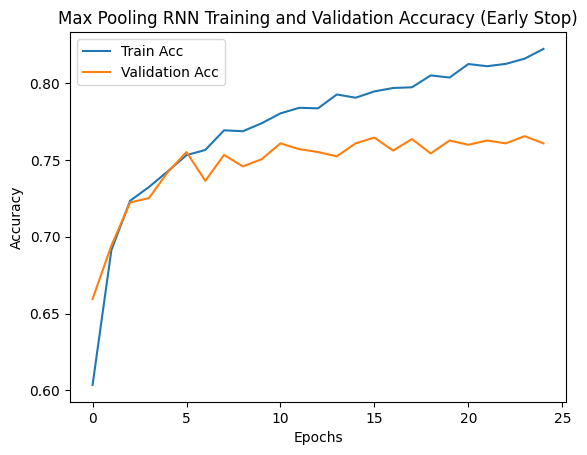

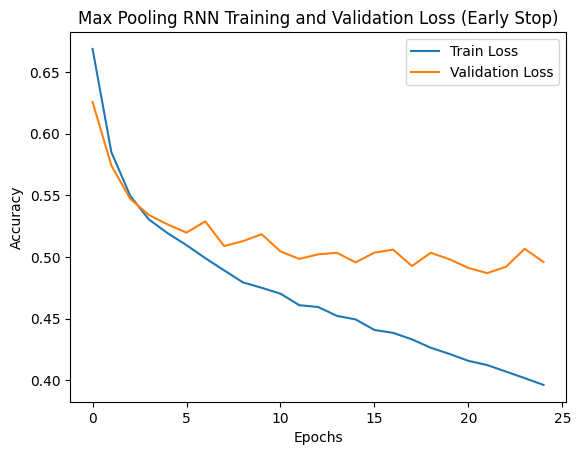

best performance (lowest validation loss) with validation acc: 0.7626641651031895 validation loss: 0.48685719686395984


In [99]:
plot({"Train Acc": train_acc, "Validation Acc": validation_acc}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Accuracy (Early Stop)")
plot({"Train Loss": train_loss, "Validation Loss": validation_loss}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Loss (Early Stop)")

i = validation_loss.index(min(validation_loss))
print("best performance (lowest validation loss) with validation acc:", validation_acc[i], "validation loss:", validation_loss[i])

In [100]:
print("Last Max Pooling RNN performance with validation acc:", validation_acc[-1], "validation loss:", validation_loss[-1], "\n")

test_accuracy = test_performance(test_dataloader, max_pool_rnn)
print("Masked Max Pooling RNN Test accuracy:", test_accuracy)

Last Max Pooling RNN performance with validation acc: 0.7607879924953096 validation loss: 0.4959140113171409 

Masked Max Pooling RNN Test accuracy: 0.7673545966228893


#### Abs Max Pooling RNN

In [140]:
# using nn.Embeddings 
import torch
import torch.nn as nn

class AbsMaxPoolRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(AbsMaxPoolRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        #print("out", out)
        # Max pooling
        # TODO: try with absolute
        abs_out = torch.abs(out)
    
        # Step 2: Find indices of maximum absolute values along dim=1
        _, indices = torch.max(abs_out, dim=1)  # indices shape: (batch_size, hidden_size)
        
        # Step 3: Gather the original values using the indices
        # Prepare indices for gathering
        indices = indices.unsqueeze(1)  # Shape: (batch_size, 1, hidden_size)
        
        # Gather the values from 'out' at the indices along dim=1
        res = out.gather(1, indices)    # Shape: (batch_size, 1, hidden_size)
        
        # Remove the singleton dimension
        res = res.squeeze(1)            # Shape: (batch_size, hidden_size)
        #print("res", res)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

In [142]:
abs_max_pool_rnn = AbsMaxPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(abs_max_pool_rnn.parameters(), lr=0.00002)
criterion = nn.BCELoss()

train_acc, validation_acc, train_loss, validation_loss = train(abs_max_pool_rnn, optim, criterion, train_dataloader, validation_dataloader, epoch=100)

Epoch 1, Train Loss: 0.6926, Validate Loss: 0.6892
Epoch:1 	 Train Acc:0.5116060961313013 	 Validation Acc:0.5656660412757973
Epoch 2, Train Loss: 0.6814, Validate Loss: 0.6792
Epoch:2 	 Train Acc:0.5821805392731536 	 Validation Acc:0.5919324577861164
Epoch 3, Train Loss: 0.6647, Validate Loss: 0.6591
Epoch:3 	 Train Acc:0.6318874560375146 	 Validation Acc:0.6285178236397748
Epoch 4, Train Loss: 0.6366, Validate Loss: 0.6316
Epoch:4 	 Train Acc:0.6531066822977726 	 Validation Acc:0.6566604127579737
Epoch 5, Train Loss: 0.6074, Validate Loss: 0.6056
Epoch:5 	 Train Acc:0.6706916764361078 	 Validation Acc:0.6838649155722326
Epoch 6, Train Loss: 0.5807, Validate Loss: 0.5812
Epoch:6 	 Train Acc:0.695662368112544 	 Validation Acc:0.6923076923076923
Epoch 7, Train Loss: 0.5637, Validate Loss: 0.5701
Epoch:7 	 Train Acc:0.7098475967174678 	 Validation Acc:0.7138836772983115
Epoch 8, Train Loss: 0.5526, Validate Loss: 0.5592
Epoch:8 	 Train Acc:0.7167643610785464 	 Validation Acc:0.7260787992

#### Sum Pooling RNN

In [101]:
# using nn.Embeddings 
import torch
import torch.nn as nn

class SumPoolRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(SumPoolRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Sum pooling
        res = torch.sum(out, dim=1)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

In [105]:
sum_pool_rnn = SumPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(sum_pool_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_sum_rnn, validation_acc_sum_rnn, train_loss_sum_rnn, validation_loss_sum_rnn = train_early_stop(sum_pool_rnn, optim, criterion, train_dataloader, validation_dataloader, patience=5)

Epoch 1, Train Loss: 0.6653, Validate Loss: 0.6122
Epoch:1 	 Train Acc:0.6150058616647128 	 Validation Acc:0.6604127579737336
Epoch 2, Train Loss: 0.5966, Validate Loss: 0.5851
Epoch:2 	 Train Acc:0.6907385697538101 	 Validation Acc:0.699812382739212
Epoch 3, Train Loss: 0.5909, Validate Loss: 0.5719
Epoch:3 	 Train Acc:0.6953106682297773 	 Validation Acc:0.7073170731707317
Epoch 4, Train Loss: 0.5790, Validate Loss: 0.5743
Epoch:4 	 Train Acc:0.7078546307151231 	 Validation Acc:0.6941838649155723
Epoch 5, Train Loss: 0.5671, Validate Loss: 0.5738
Epoch:5 	 Train Acc:0.7118405627198124 	 Validation Acc:0.7110694183864915
Epoch 6, Train Loss: 0.5687, Validate Loss: 0.5602
Epoch:6 	 Train Acc:0.7116060961313013 	 Validation Acc:0.7063789868667918
Epoch 7, Train Loss: 0.5600, Validate Loss: 0.5548
Epoch:7 	 Train Acc:0.7218053927315358 	 Validation Acc:0.723264540337711
Epoch 8, Train Loss: 0.5557, Validate Loss: 0.5695
Epoch:8 	 Train Acc:0.7209847596717468 	 Validation Acc:0.70356472795

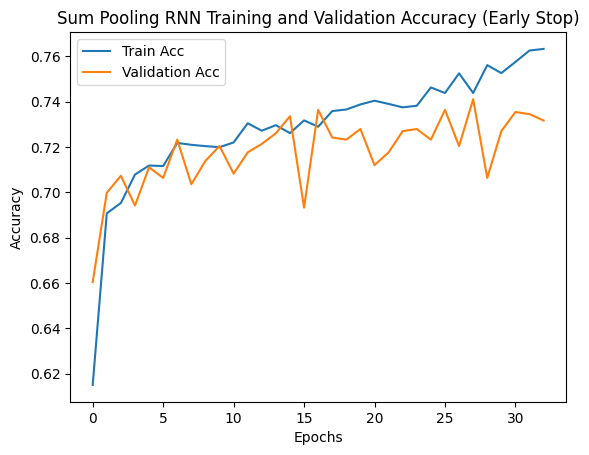

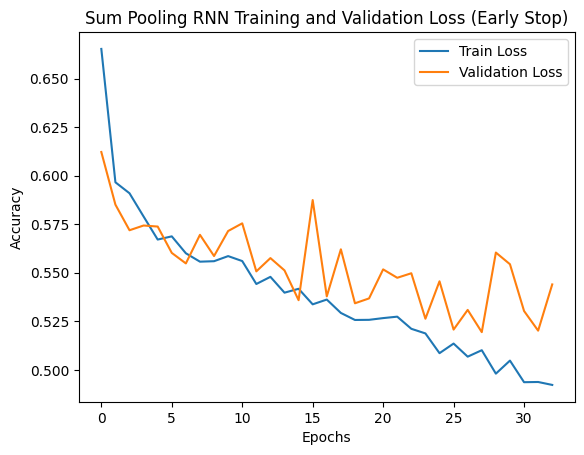

best performance (lowest validation loss) with validation acc: 0.7410881801125704 validation loss: 0.5194205352488686


In [107]:
plot({"Train Acc": train_acc_sum_rnn, "Validation Acc": validation_acc_sum_rnn}, x_label="Epochs", y_label="Accuracy", title="Sum Pooling RNN Training and Validation Accuracy (Early Stop)")
plot({"Train Loss": train_loss_sum_rnn, "Validation Loss": validation_loss_sum_rnn}, x_label="Epochs", y_label="Accuracy", title="Sum Pooling RNN Training and Validation Loss (Early Stop)")


i = validation_loss_sum_rnn.index(min(validation_loss_sum_rnn))
print("best performance (lowest validation loss) with validation acc:", validation_acc_sum_rnn[i], "validation loss:", validation_loss_sum_rnn[i])

In [109]:
print("Last Sum Pooling RNN performance with validation acc:", validation_acc_sum_rnn[-1], "validation loss:", validation_loss_sum_rnn[-1], "\n")

test_accuracy = test_performance(test_dataloader, sum_pool_rnn)
print("Sum Pooling RNN Test accuracy:", test_accuracy)

Last Sum Pooling RNN performance with validation acc: 0.7317073170731707 validation loss: 0.5439877825624803 

Sum Pooling RNN Test accuracy: 0.7345215759849906


#### Mean Pooling RNN

In [110]:
# using nn.Embeddings 
import torch
import torch.nn as nn

class MeanPoolRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(MeanPoolRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Mean pooling
        res = torch.mean(out, dim=1)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

In [111]:
mean_pool_rnn = MeanPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(mean_pool_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_mean_rnn, validation_acc_mean_rnn, train_loss_mean_rnn, validation_loss_mean_rnn = train_early_stop(mean_pool_rnn, optim, criterion, train_dataloader, validation_dataloader, patience=5)

Epoch 1, Train Loss: 0.6573, Validate Loss: 0.6468
Epoch:1 	 Train Acc:0.6016412661195779 	 Validation Acc:0.6360225140712945
Epoch 2, Train Loss: 0.5832, Validate Loss: 0.5806
Epoch:2 	 Train Acc:0.693200468933177 	 Validation Acc:0.7091932457786116
Epoch 3, Train Loss: 0.5582, Validate Loss: 0.5675
Epoch:3 	 Train Acc:0.7133645955451349 	 Validation Acc:0.7176360225140713
Epoch 4, Train Loss: 0.5456, Validate Loss: 0.5546
Epoch:4 	 Train Acc:0.7250879249706916 	 Validation Acc:0.7176360225140713
Epoch 5, Train Loss: 0.5395, Validate Loss: 0.5541
Epoch:5 	 Train Acc:0.723915592028136 	 Validation Acc:0.7213883677298312
Epoch 6, Train Loss: 0.5385, Validate Loss: 0.5585
Epoch:6 	 Train Acc:0.7254396248534584 	 Validation Acc:0.699812382739212
Epoch 7, Train Loss: 0.5335, Validate Loss: 0.5602
Epoch:7 	 Train Acc:0.7295427901524033 	 Validation Acc:0.7063789868667918
Epoch 8, Train Loss: 0.5289, Validate Loss: 0.5510
Epoch:8 	 Train Acc:0.7337631887456038 	 Validation Acc:0.711069418386

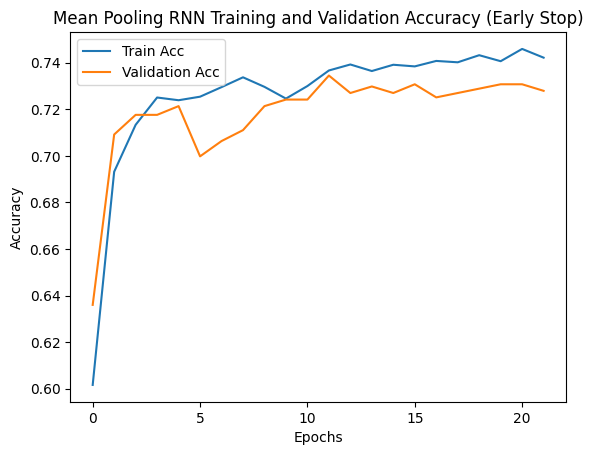

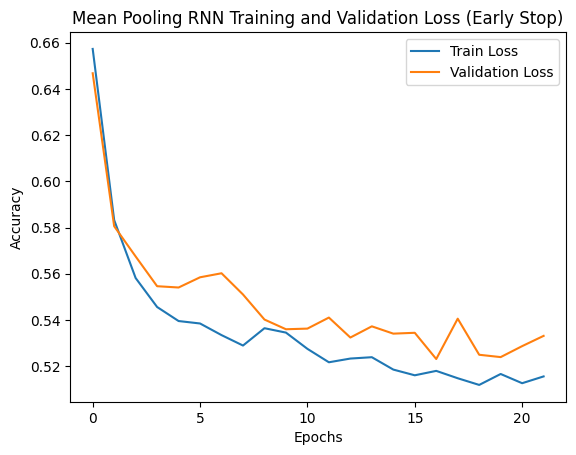

best performance (lowest validation loss) with validation acc: 0.7345215759849906 validation loss: 0.5410483067526537


In [115]:
plot({"Train Acc": train_acc_mean_rnn, "Validation Acc": validation_acc_mean_rnn}, x_label="Epochs", y_label="Accuracy", title="Mean Pooling RNN Training and Validation Accuracy (Early Stop)")
plot({"Train Loss": train_loss_mean_rnn, "Validation Loss": validation_loss_mean_rnn}, x_label="Epochs", y_label="Accuracy", title="Mean Pooling RNN Training and Validation Loss (Early Stop)")

i = validation_acc_mean_rnn.index(max(validation_acc_mean_rnn))
print("best performance (lowest validation loss) with validation acc:", max(validation_acc_mean_rnn), "validation loss:", validation_loss_mean_rnn[i])

In [114]:
print("Last Mean Pooling RNN performance with validation acc:", validation_acc_mean_rnn[-1], "validation loss:", validation_loss_mean_rnn[-1], "\n")

test_accuracy = test_performance(test_dataloader, mean_pool_rnn)
print("Mean Pooling RNN Test accuracy:", test_accuracy)

Last Mean Pooling RNN performance with validation acc: 0.7279549718574109 validation loss: 0.5331267249934813 

Mean Pooling RNN Test accuracy: 0.7514071294559099
